# Project2
Новак Евгений <br>
Орлов Григорий <br>
Тожимухаммедов Асадбек <br>
Вариант: 1

----

## Условие: <br>
* **Реализовать метод наискорейшего спуска (золотое сечение), метод Левенберга-Марквартда**<br>

* **Тестовые функции**

1. Расчет минимума сильно-выпуклой функции:
		$$
		f(x) = \frac{L - \mu}{8} \left[ x_1^2 + \sum_{i=2}^n (x_i - x_{i+1})^2 - 2x_1 \right] + \frac{\mu}{2} \| x \|_2^2
		$$
		Полагаем $ L = 100, \mu = 0.1 $.

2. Расчет двойственной задачи к задаче расчета матрицы корреспонденций:
		$$
		f(x, y) = -(L, x) - (W, y) + \ln \left[ \sum_{i,j} \exp(-\alpha c_{ij} + x_i + y_j) \right]
		$$  
		Здесь: $ x \in R^n, \, y \in R^n, \, L, W \in R_{+}^n, \, \| L \|_1 = 1, \, \| W \|_1 = 1, \, \alpha \geq 1, \, c_{ij} \in [0, 1] $. Параметры $ L, W, c $ задаются случайно, $ \alpha = 100 $.

3. Функция Розенброка ($ x \in R^n, \, x^* \equiv 1_n, \, f^* = 0 $):  
		$$
		f(x) = (x_1 - 1)^2 + \alpha \sum_{i=2}^n (x_i - x_{i-1}^2)^2.
		$$  
		Параметр $ \alpha $ можно варьировать. Для тестов возьмем его 10.

4. Задача энтропийно-линейного программирования без ограничений:
		$$
		f(x) = \sum_{i=1}^n x_i \ln \frac{x_i}{\xi_i}, \, x \in R_{+}^n; \, (n = 10, \ldots 1000); \, \xi_i = 1/i
		$$

5. Линейная регрессия:
		$$
		f(x) = \sum_{i=1}^m ((a^i, x) - b_i)^2
		$$  
		Параметр $ m = 100, \, $ значения $ a^i \in R^n, \, b_i $ выбираются случайно.

6. Функция правдоподобия:
		$$
		f(x,y) = -\sum_{i=1}^{k}(x^T a^i + y) + \sum_{i=1}^{m}\ln(1 + \exp(x^T a^i + y))
		$$

* **Комментарии**

1. Начальная точка выбирается случайно на достаточно большом удалении от оптимальной точки. Расстояние фиксируется одним и тем же для разных размерностей задачи.  
2. Точность решения варьируется от $10^{-4}$ до $10^{-5}$ с шагом $10^{-5}$.  
3. Точность одномерного поиска варьируется от $10^{-7}$ до $10^{-8}$ с шагом $10^{-8}$.  
4. Размерность задачи варьируется: 10, 20, 30, 40, 50, 60, 60, 70, 80, 90, 100, 200, 400, 600, 800, 1000.  

* **Графики**

1. Для фиксированных выбранных значений точности одномерного поиска и точности решения задачи по функции построить график зависимости времени решения от размерности задачи.  
2. Для фиксированных выбранных значений размерности задачи и точности одномерного поиска построить график зависимости времени решения задачи от требуемой точности решения задачи по функции.  
3. Для фиксированных выбранных значений размерности и точности решения задачи по функции построить график зависимости времени решения от точности одномерного поиска.  
4. Для фиксированных выбранных значений точности одномерного поиска, размерности задачи и точности решения задачи по функции построить график зависимости времени решения от расстояния между начальной точкой и оптимальной точкой.  

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as agnp
import numpy as np
import autograd as ag
import copy
from typing import Callable
from typing import Dict, Any, Tuple
import time

In [2]:
# Eugine
# Метод золотого сечения из прошлого проекта


def golden_section_search(
    f: Callable[[float, agnp.ndarray], float], a: float, b: float, d:agnp.ndarray, eps: float
) -> tuple[float, list, list, int]:
    phi = (1 + np.sqrt(5)) / 2
    x1 = a + (b - a) / (phi + 1)
    x2 = b - (b - a) / (phi + 1)
    f1, f2 = f(x1, d), f(x2, d)

    iter_num, lst_x, lst_y = 0, [], []
    lst_x.append(0)
    lst_y.append((a + b) / 2)

    while abs(b - a) > eps:
        iter_num += 1
        if f1 < f2:
            b = x2
            x2, f2 = x1, f1
            x1 = a + (b - a) / (phi + 1)
            f1 = f(x1, d)
        else:
            a = x1
            x1, f1 = x2, f2
            x2 = b - (b - a) / (phi + 1)
            f2 = f(x2, d)

        lst_x.append(iter_num)
        lst_y.append((a + b) / 2)
    return ((a + b) / 2, copy.deepcopy(lst_x), copy.deepcopy(lst_y), iter_num)

In [68]:
# Eugine

eps_fastest = 10 ** (-4)
eps_golden = 10 ** (-7)


def the_fastest_descent(f: Callable[[agnp.ndarray, Dict[str, Any]], float],
    param_list: Dict[str, Any],
    x0: agnp.ndarray,
    max_steps: int,
    eps: float,
) -> Tuple[agnp.ndarray, ...]:
    x_old = agnp.copy(x0)
    
    def func_of_h(h: float, d: agnp.ndarray) -> float:
        return f(x_old + h * d, param_list)

    d = -ag.grad(f, argnum=0)(x_old, param_list)        #-numerical_gradient(f, x0)
    while agnp.linalg.norm(d) ** 2 > eps and max_steps > 0:
        max_steps -= 1
        x_new = x_old + (golden_section_search(func_of_h, 0, 4, d, eps_golden)[0]) * d
        d = -ag.grad(f, argnum=0)(x_new, param_list)
        x_old = agnp.copy(x_new)

    print(f(x_new, param_list))
    return x_new



def quadratic1d(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2    

param_list, x0, max_steps, eps = {}, agnp.array([1.0, 0.9, -1]), 100, 1e-6
result = the_fastest_descent(quadratic1d, param_list, x0, max_steps, eps)
print("Quadratic1d:", result)  # Ожидается ~[(0, 0, 0)]

4.3715361757243474e-16
Quadratic1d: [ 1.24727977e-08  1.12255180e-08 -1.24727977e-08]


In [37]:
# asadbek levenberg_markvatd

def hessian(func, x: np.ndarray):
    return ag.jacobian(ag.grad(func))(x)


def levenberg_markvatd2(
    f: Callable[[agnp.ndarray, Dict[str, Any]], float],
    param_list: Dict[str, Any],
    x0: agnp.ndarray,
    max_steps: int,
    eps: float,
) -> Tuple[agnp.ndarray, ...]:
    alpha = 10**4
    x_old = agnp.copy(x0)
    x_len = len(x_old)

    for _ in range(max_steps):
        grad_f = ag.grad(f, argnum=0)(x_old, param_list)
        H = hessian(lambda args: f(args, param_list), x_old)

        sk = agnp.linalg.inv(H + alpha * agnp.eye(x_len)) @ grad_f
        x_new = agnp.copy(x_old - sk)
        if f(x_new, param_list) < f(x_old, param_list):
            alpha /= 2
        else:
            alpha *= 2

        if agnp.linalg.norm(x_new - x_old) < eps:
            print(f(x_new, param_list))
            return x_new

        x_old = agnp.copy(x_new)

    print(f(x_new, param_list))
    return x_new


def quadratic1d(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2

param_list, x0, max_steps, eps = {}, agnp.array([1.0, 0.9, -1]), 100, 1e-6
result = levenberg_markvatd2(quadratic1d, param_list, x0, max_steps, eps)
print("Quadratic1d:", result)  # Ожидается ~[(0, 0, 0)]

5.7842809631020944e-18
Quadratic1d: [ 1.43473446e-09  1.29126102e-09 -1.43473446e-09]


In [5]:
# test funcs
# сигнатура: (args: , param_list: Dict[str, Any])


# Сильно-выпуклая функция
def strongly_convex(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    L, mu = param_list["L"], param_list["mu"]
    return ((L - mu) / 8) * (x[0] ** 2 + agnp.sum((x[:-1] - x[1:]) ** 2) - 2 * x[0]) + (mu / 2) * agnp.linalg.norm(
        x
    ) ** 2


# Двойственная задача матрицы корреспонденций
def dual_correspondence(
    x: agnp.ndarray,
    param_list: Dict[str, Any],
) -> float:
    x0 = x[:len(x)//2]
    y0 = x[len(x)//2:] 
    L, W, c = param_list["L"], param_list["W"], param_list["c"]
    return -agnp.dot(L, x0) - agnp.dot(W, y0) + agnp.log(agnp.sum(agnp.exp(-100 * c + x0[:, None] + y0[None, :])))


# Функция Розенброка
def rosenbrock(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    alpha_rosenbrock = param_list["alpha_rosenbrock"]
    return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)


# Энтропийно-линейная функция
def entropy_linear(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    xi = param_list["xi"]
    return agnp.sum(x * agnp.log(x / xi))


# Линейная регрессия
def linear_regression(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    A, b = param_list["A"], param_list["b"]
    return agnp.sum((A @ x - b) ** 2)


# Функция правдоподобия
def likelihood_function(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    x0 = x[:-1]
    y = x[len(x) - 1]
    A = param_list["A"]
    bias = y * agnp.ones((A.shape[0],))
    linear_term = A @ x0 + bias
    return -agnp.sum(linear_term) + agnp.sum(agnp.log(1 + agnp.exp(linear_term)))


function_list = [
    strongly_convex,
    dual_correspondence,
    rosenbrock,
    entropy_linear,
    linear_regression,
    likelihood_function,
]

func_name_list = [
    "StronglyConvex",
    "DualCorrespondence",
    "Rosenbrock",
    "EntropyLinear",
    "LinearRegression",
    "LikelihoodFunction",
]

dimemsions = [10, 20, 30, 40, 50, 60, 60]

number_of_func = 6

# Пример для StronglyConvex
def param_gen_1(n):
    x = agnp.random.randn(n)
    param_list = {"L": 100, "mu": 0.1}
    return (x, param_list)

def param_gen_2(n):
    x = agnp.random.randn(n)
    y = agnp.random.randn(n)
    L = agnp.abs(agnp.random.rand(n))
    W = agnp.abs(agnp.random.rand(n))
    L /= agnp.sum(L)
    W /= agnp.sum(W)
    c = agnp.random.rand(n, n)
    param_list = {"L": L, "W": W, "c": c}
    return (agnp.concatenate((x,y)), param_list)

def param_gen_3(n):
    x = agnp.random.randn(n)
    param_list = {"alpha_rosenbrock": 100}
    return (x, param_list)

def param_gen_4(n):
    x = agnp.abs(agnp.random.rand(n))  # Должно быть положительным
    param_list = {"xi": 1 / agnp.arange(1, n + 1)}
    return (x, param_list)

def param_gen_5(n):
    m = 100
    x = agnp.random.randn(n)
    A = agnp.random.randn(m, n)
    b = agnp.random.randn(m)
    param_list = {"A": A, "b": b}
    return (x, param_list)

def param_gen_6(n):
    m = 100
    x = agnp.random.randn(n)
    y = agnp.random.randn(1)
    A = agnp.random.randn(m, n)
    param_list = {"A": A}
    return (agnp.concatenate((x, y)), param_list)

param_gen = [
    param_gen_1,
    param_gen_2,
    param_gen_3,
    param_gen_4,
    param_gen_5,
    param_gen_6
]

In [70]:
#Для наглядности добавил вывод значения функции перед return-ом.
# run on test funcs 

# запуск на StronglyConvex
n = 1
x0, param_list = param_gen[0](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(strongly_convex, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(strongly_convex, param_list, x0, max_steps, eps)
print("StronglyConvex:", result1, result2)


# запуск на DualCorrespondence
n = 2
x0, param_list = param_gen[1](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(dual_correspondence, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(dual_correspondence, param_list, x0, max_steps, eps)
print("DualCorrespondence:", result1, result2)

# запуск на Rosenbrock
n = 15
x0, param_list = param_gen[2](n)
max_steps, eps = 1000, 1e-12
result1 = levenberg_markvatd2(rosenbrock, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(rosenbrock, param_list, x0, max_steps, eps)
print("Rosenbrock:", result1, result2)

# запуск на EntropyLinear
n = 5
x0, param_list = param_gen[3](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(entropy_linear, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(entropy_linear, param_list, x0, max_steps, eps)
print("EntropyLinear:", result1, result2)


# запуск на LinearRegression
n = 6
x0, param_list = param_gen[4](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(linear_regression, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(linear_regression, param_list, x0, max_steps, eps)
print("LinearRegression:", result1, result2)

# запуск на LikelihoodFunction
n = 5
x0, param_list = param_gen[5](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(likelihood_function, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(likelihood_function, param_list, x0, max_steps, eps)
print("LikelihoodFunction:", result1, result2)

-12.437699401794614
-12.437699401787091
StronglyConvex: [0.99601195] [0.99601274]
nan
-10.049689984817386
DualCorrespondence: [nan nan nan nan] [-20.88351372  20.65398857 -20.65921532  17.08115518]
0.0
0.03833924505325414
Rosenbrock: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [8.04714446e-001 6.46295600e-001 4.17182333e-001 1.73667521e-001
 3.00593111e-002 8.97247074e-004 7.93966370e-007 6.13095683e-013
 3.55659205e-025 1.13381219e-049 1.03813396e-098 7.16167827e-197
 0.00000000e+000 0.00000000e+000 0.00000000e+000]
-0.8399913906747595
nan
EntropyLinear: [0.3678796  0.18393972 0.12262648 0.09196986 0.07357589] [-0.52583803  3.16900635 -1.51434614  3.89039805 -6.15682764]
78.11200561635395
78.112005623012
LinearRegression: [-0.1574613   0.02783618 -0.15309077  0.08604573  0.13534172  0.00752732] [-0.15746622  0.02783528 -0.15309398  0.08604888  0.1353442   0.00753141]
0.0
0.003152398002839618
LikelihoodFunction: [-8.03553908e-02  2.64128387e-01 -4.95132699e-02  9.40312654e-02
  2.53

C:\Users\Admin\AppData\Local\Temp\ipykernel_15312\1602315112.py:27: RuntimeWarning: overflow encountered in square
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)
C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15312\1602315112.py:27: RuntimeWarning: overflow encountered in scalar multiply
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)
C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in multiply
  return f_raw(*args, **kwargs)


[0.008328676223754883, 0.012822866439819336, 0.016674518585205078, 0.021030664443969727, 0.025198698043823242, 0.031099557876586914, 0.029597043991088867]
[0.05947065353393555, 0.07268214225769043, 0.08319354057312012, 10.008726596832275, 0.3905653953552246, 0.48372530937194824, 0.5430641174316406]
[0.0027379989624023438, 0.004195213317871094, 0.005627632141113281, 0.006838798522949219, 0.008359193801879883, 0.009751319885253906, 0.009510040283203125]
[0.003922939300537109, 0.06245279312133789, 0.08711624145507812, 0.1244039535522461, 0.14683985710144043, 0.19460415840148926, 0.19443726539611816]
[0.006200075149536133, 0.008263349533081055, 0.017690658569335938, 0.027518272399902344, 0.02697277069091797, 0.029015541076660156, 0.03209495544433594]


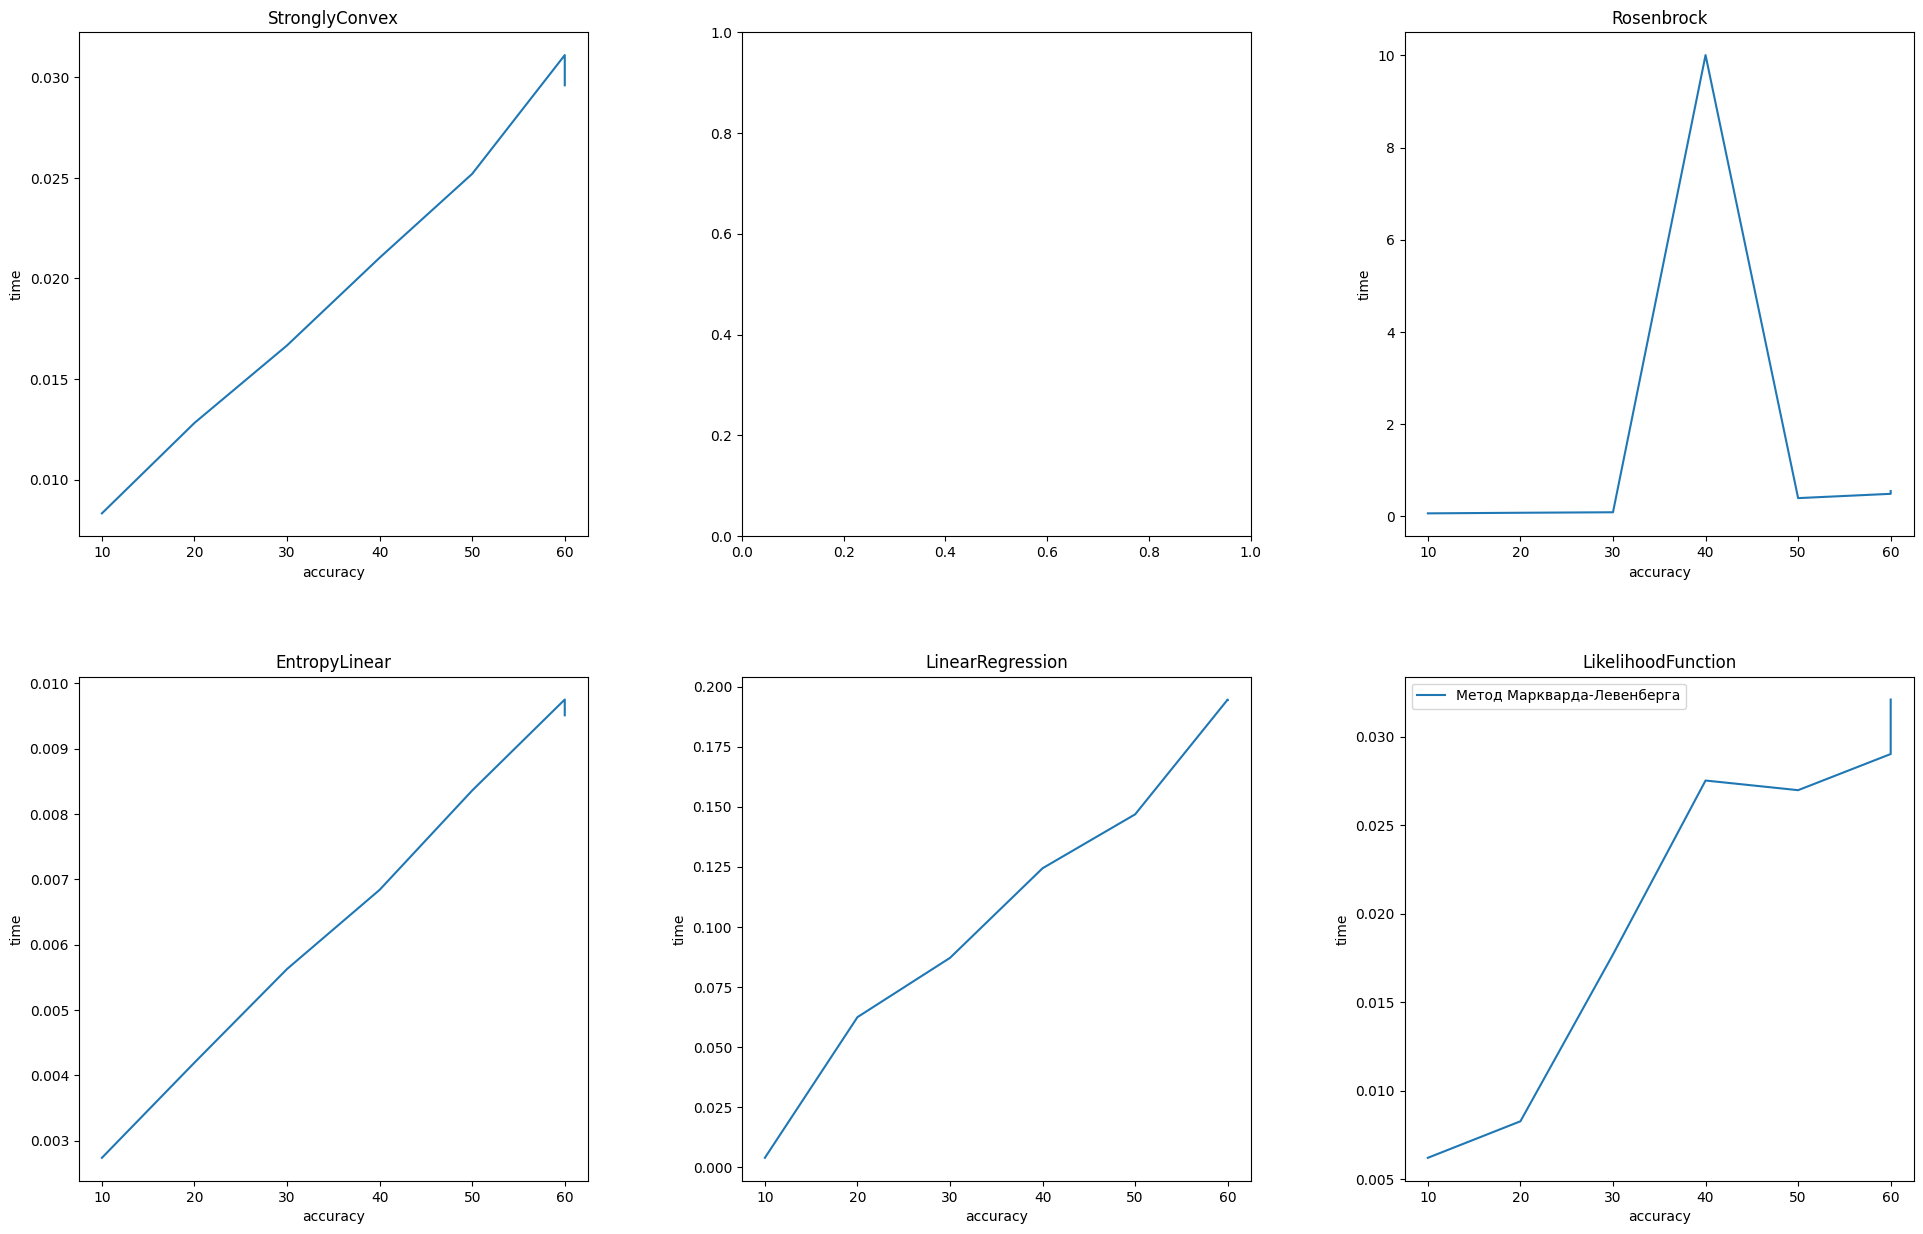

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))  # figsize=(ширина, высота)
plt.tight_layout(pad=8.0)

prec = 1e-1
steps = 1000

Lst_y = []

for i in range(number_of_func):
    Lst_y.append([])
    for dim in dimemsions:
        start_time = time.time()
        x0, param_list = param_gen[i](dim)
        max_steps, eps = steps, prec
        result = levenberg_markvatd2(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_y[i].append(end_time - start_time)


for i in range(2):
    for j in range(3):
        if i == 0 and j == 1:
            continue
        ind = i * 3 + j
        print(Lst_y[ind])
        axs[i, j].plot(dimemsions, Lst_y[ind], label='Метод Маркварда-Левенберга')
        axs[i, j].set_title(func_name_list[ind])
        axs[i, j].set_xlabel('accuracy')
        axs[i, j].set_ylabel('time')
        
plt.legend()
plt.show()